# __DOC EMBEDDING EXP#1__

In [1]:
import numpy as np
import pandas as pd
import math
from gensim.models import Word2Vec
from gensim import corpora
from nltk.corpus import stopwords
from fse.models import Average
from fse import IndexedList
import sklearn.decomposition
import sklearn.manifold
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
speech = pd.read_csv('../dataset/archive/presidential_speeches.csv')
# one presentation has no transcript so I drop it
speech = speech[pd.isna(speech['Transcript']) == False]
# reset the index
speech.reset_index(drop=True, inplace=True)

In [3]:
speech.head(5)

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...


In [3]:
# I haven't found any good pretrained doc2vec model that we can use, so I just trained a new one using our transcripts

# create and clean the corpus
corpus = speech['Transcript'].values
texts = [[word.lower() for word in doc.split() if word not in stopwords.words('english')] for doc in corpus]
# # develop a word2vec model first
# w2vmodel = Word2Vec(texts, vector_size=100, window=10)
# # use FastText to train doc2vec
# d2vmodel = Average(w2vmodel)
# d2vmodel.train(IndexedList(texts))

In [42]:
print(f'The size of the document embedding space is: {d2vmodel.sv[0].shape[0]}')

The size of the document embedding space is: 100


In [4]:
# encode president names to numbers
presidents_names = list(set(speech.President.values))
labels = [presidents_names.index(name) for name in speech.President.values]

In [61]:
# T-SNE
tsneDoc = sklearn.manifold.TSNE(n_components=2).fit_transform(d2vmodel.sv.vectors)

/Users/shiyang/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/shiyang/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


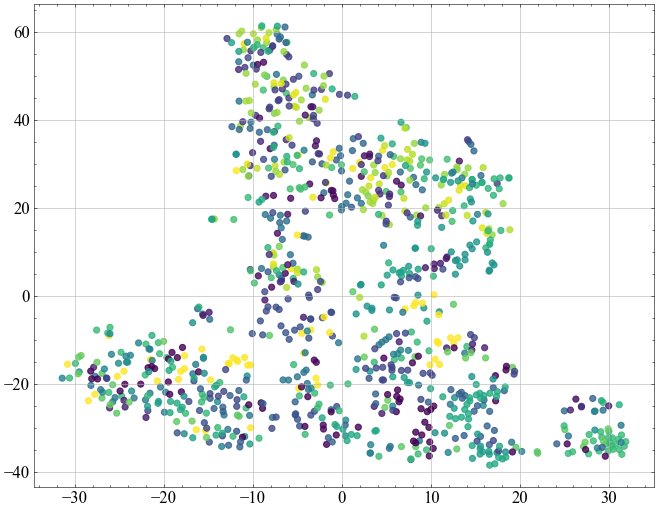

In [74]:
# visualize the embedding
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(tsneDoc[:, 0], tsneDoc[:, 1], c=labels, s=30, alpha=0.8, label=presidents_names)
# plt.legend()
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [5]:
# # label via context
context = pd.read_csv('../dataset/archive/presidential_speeches_manual_labels.csv')
speech = pd.merge(speech, context[['URL', 'Context']], on='URL', how='inner')
speech[speech.Context == 'Wwar'].loc['Context'] = 'War'
context_names = list(set(speech.Context.values))
labels = [context_names.index(name) for name in speech.Context.values]

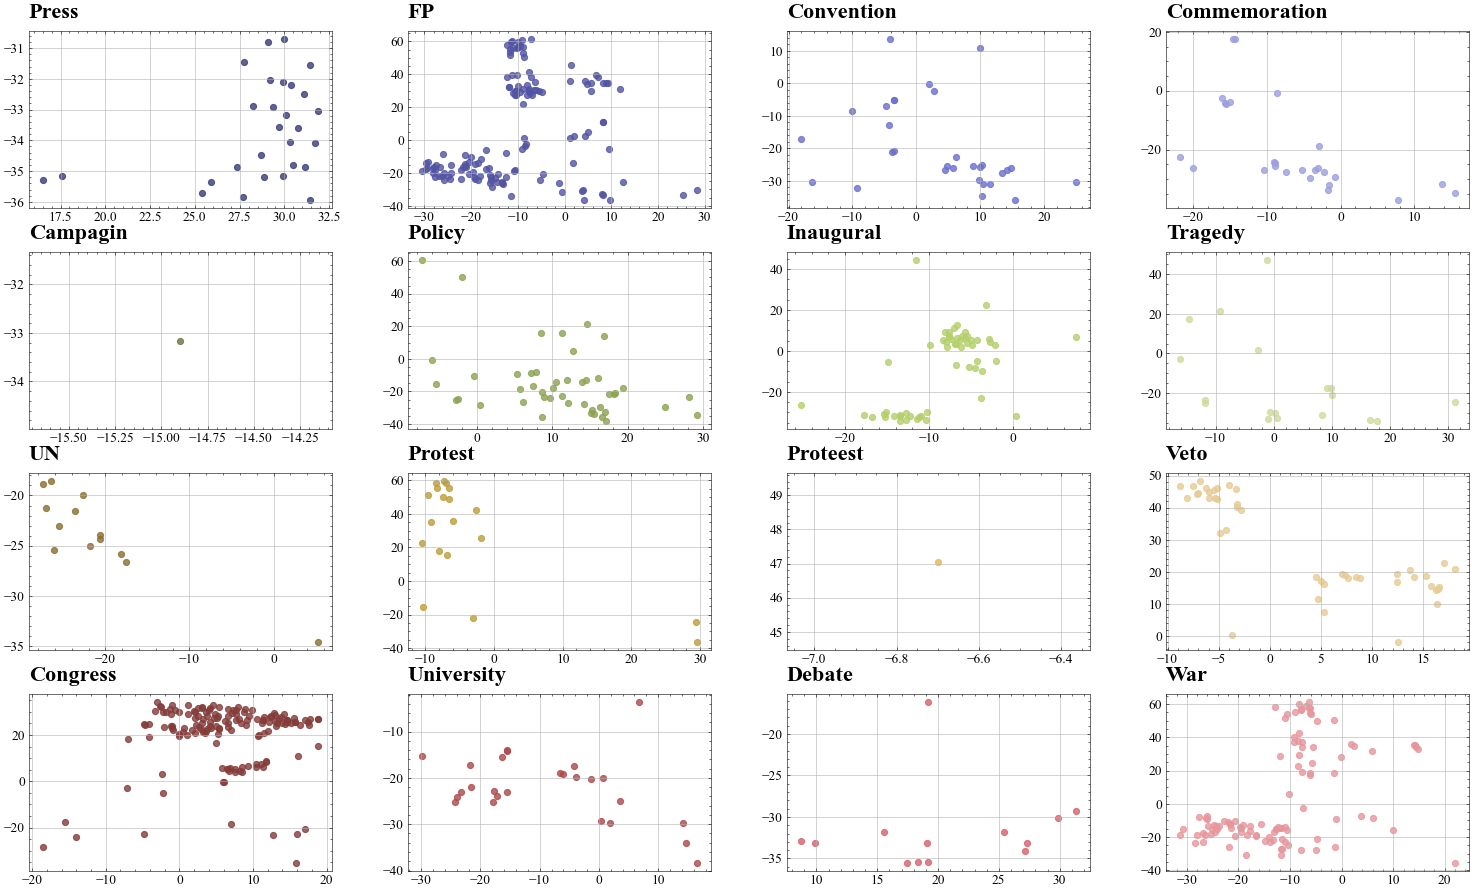

In [157]:
# visualize the embedding
fig, axis = plt.subplots(4, 4, figsize=(20, 15), dpi=80)
context_names = context_names[1:]
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
for i, context_name in enumerate(context_names):
    x_index = speech[speech.Context == context_name].index.values
    axis[i//4, i%4].set_title(context_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//4, i%4].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=context_name)
    axis[i//4, i%4].tick_params(axis='both', which='major', labelsize=12)
    axis[i//4, i%4].grid()
    if i == 15:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

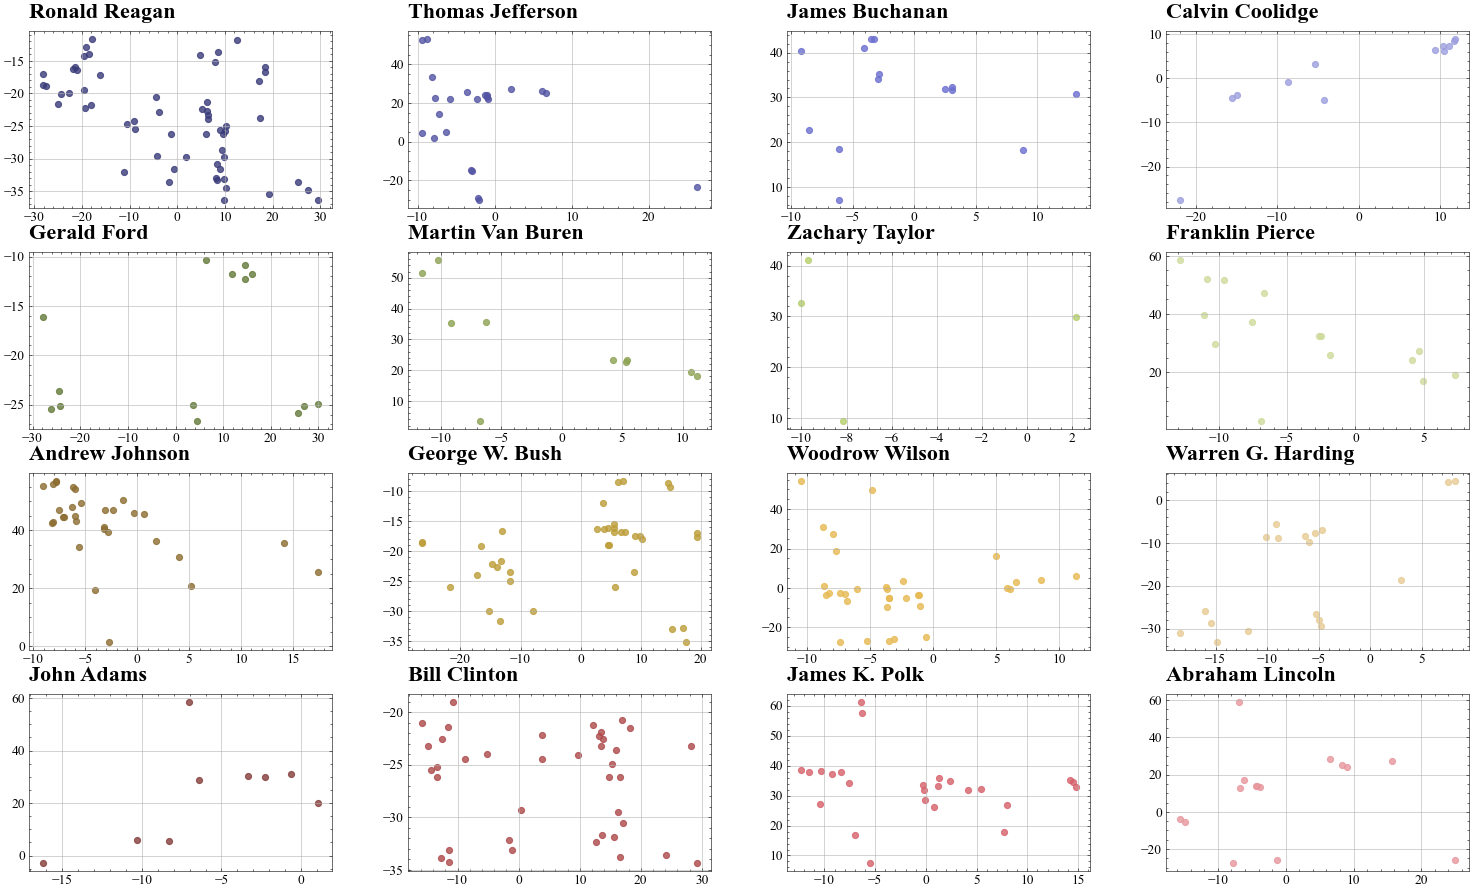

In [166]:
# encode president names to numbers
presidents_names = list(set(speech.President.values))
labels = [presidents_names.index(name) for name in speech.President.values]
fig, axis = plt.subplots(4, 4, figsize=(20, 15), dpi=80)
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
for i, president_name in enumerate(presidents_names):
    x_index = speech[speech.President == president_name].index.values
    axis[i//4, i%4].set_title(president_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//4, i%4].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=president_name)
    axis[i//4, i%4].tick_params(axis='both', which='major', labelsize=12)
    axis[i//4, i%4].grid()
    if i == 15:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

In [179]:
speech['fasttext_emb'] = [','.join(vec.astype(str)) for vec in d2vmodel.sv.vectors]
speech.to_csv('speech_with_emb.csv')

# __DOC EMBEDDING EXP#2__

In [6]:
# use gensim pre-trained word2vec model
import gensim.downloader as api
# I use fasttext-wiki-news-subwords-300 model
wv = api.load('fasttext-wiki-news-subwords-300')

In [7]:
# fast text model
d2vmodel = Average(wv)
d2vmodel.train(IndexedList(texts))

(991, 1750964)

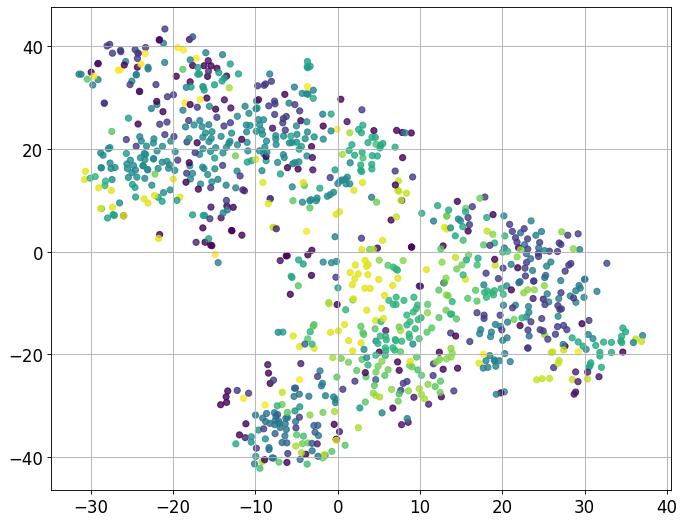

In [8]:
# T-SNE
tsneDoc = sklearn.manifold.TSNE(n_components=2).fit_transform(d2vmodel.sv.vectors)
fig = plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(tsneDoc[:, 0], tsneDoc[:, 1], c=labels, s=30, alpha=0.8, label=presidents_names)
# plt.legend()
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

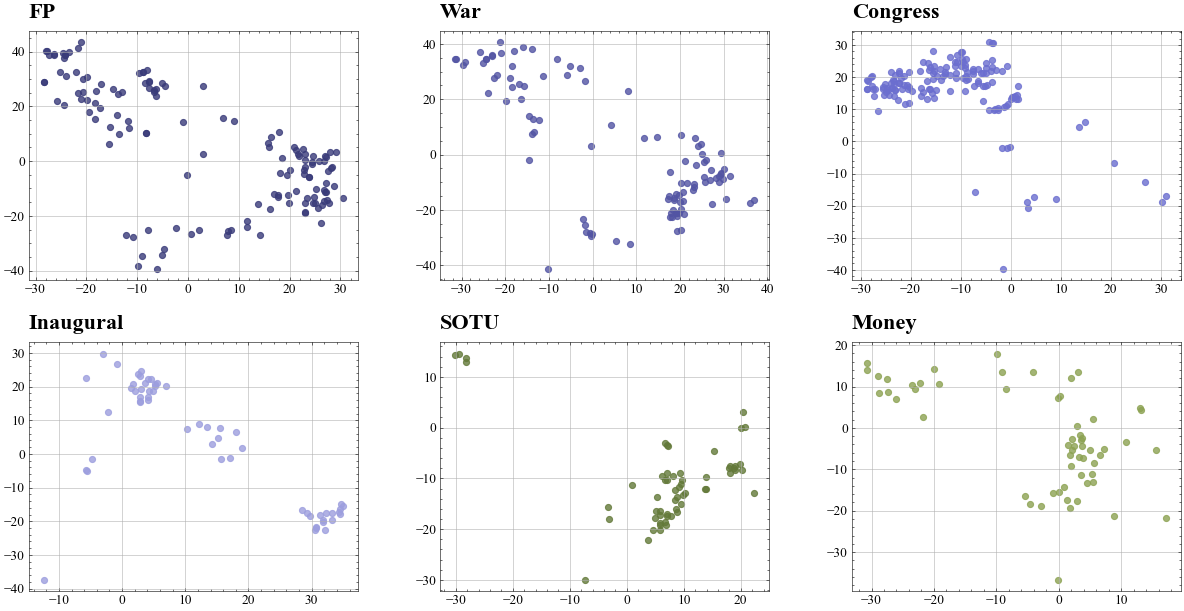

In [9]:
# visualize the embedding
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'
fig, axis = plt.subplots(2, 3, figsize=(16, 10), dpi=80)
# context_names = context_names[1:]
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
i = 0
for context_name in context_names:
    x_index = speech[speech.Context == context_name].index.values
    if len(x_index) <= 50:
        continue
    axis[i//3, i%3].set_title(context_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//3, i%3].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=context_name)
    axis[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)
    axis[i//3, i%3].grid()
    i += 1
    if i == 9:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

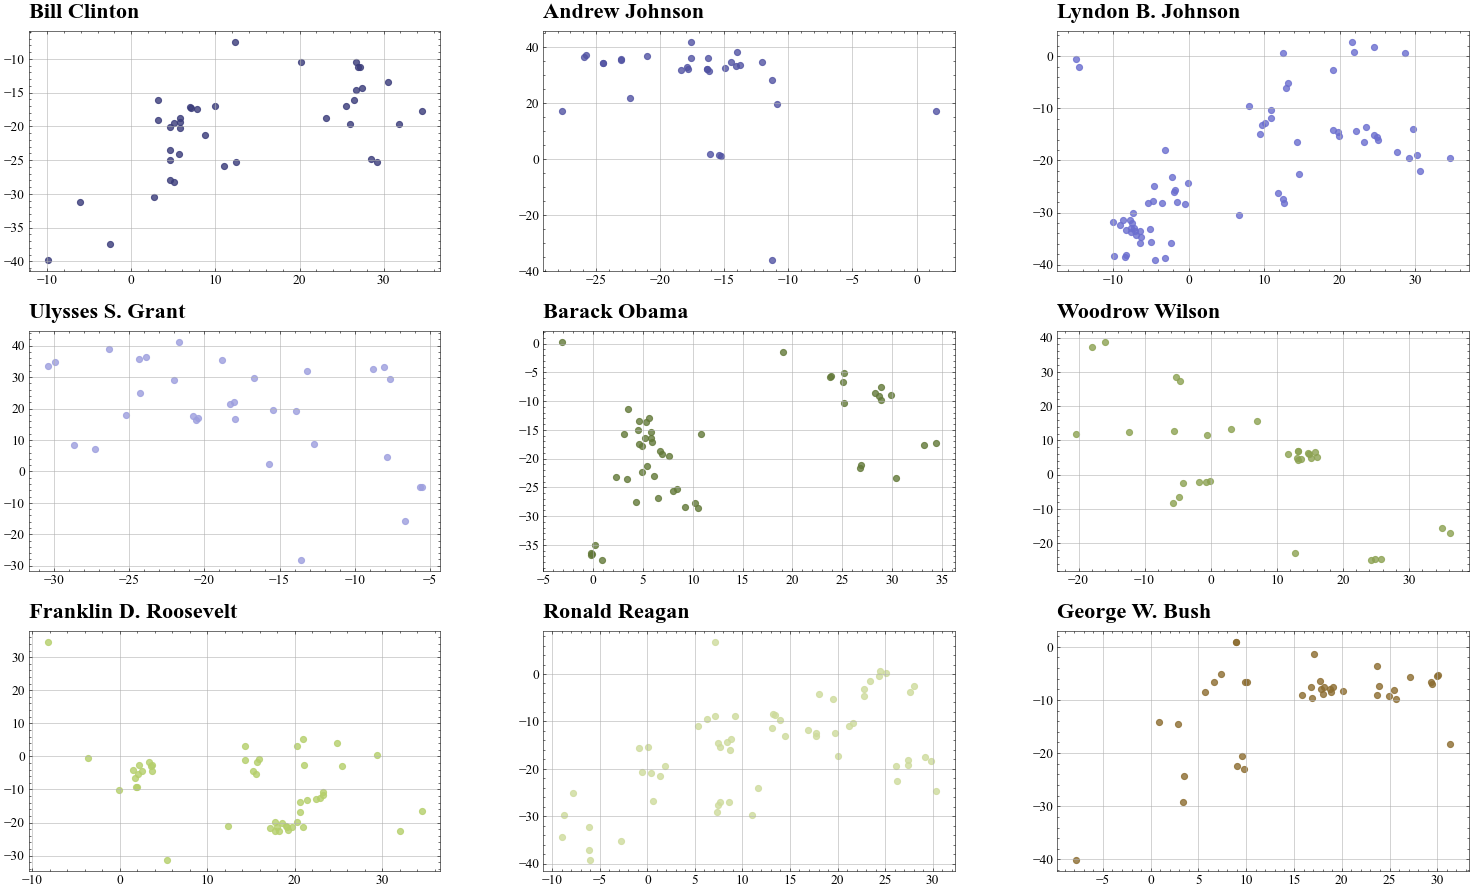

In [10]:
# encode president names to numbers
presidents_names = list(set(speech.President.values))
labels = [presidents_names.index(name) for name in speech.President.values]
fig, axis = plt.subplots(3, 3, figsize=(20, 15), dpi=80)
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
i = 0
for president_name in presidents_names:
    x_index = speech[speech.President == president_name].index.values
    if len(x_index) <= 30:
        continue
    axis[i//3, i%3].set_title(president_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//3, i%3].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=president_name)
    axis[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)
    axis[i//3, i%3].grid()
    i += 1
    if i == 9:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

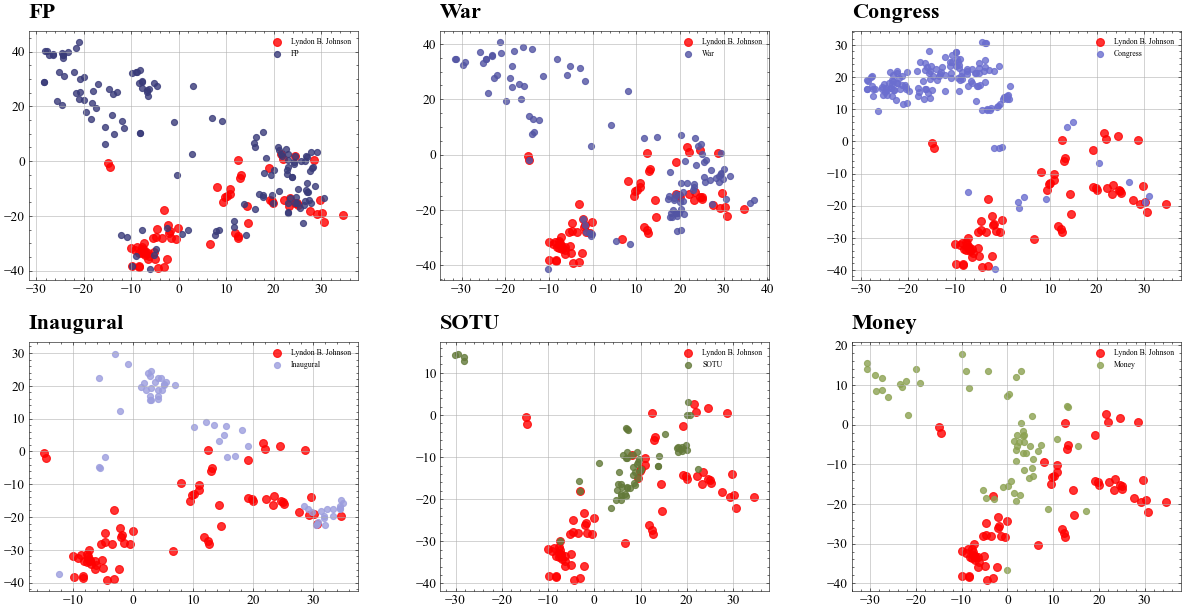

In [11]:
# visualzie Lyndon B.Jonson
fig, axis = plt.subplots(2, 3, figsize=(16, 10), dpi=80)
# context_names = context_names[1:]
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
i = 0
president = 'Lyndon B. Johnson'
for context_name in context_names:
    x_index = speech[speech.Context == context_name].index.values
    if len(x_index) <= 50:
        continue
    president_position = speech[speech.President == president].index.values
    axis[i//3, i%3].scatter(tsneDoc[president_position, 0], tsneDoc[president_position, 1], color='red', s=50, alpha=0.8, label=president)
    axis[i//3, i%3].set_title(context_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//3, i%3].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=context_name)
    axis[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)
    axis[i//3, i%3].legend()
    axis[i//3, i%3].grid()
    i += 1
    if i == 9:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

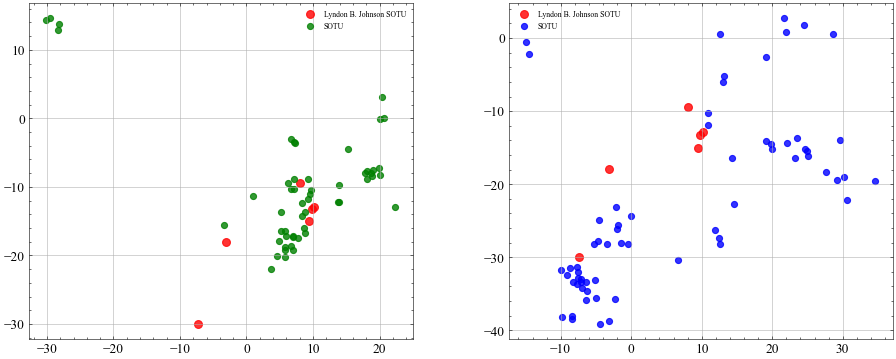

In [12]:
# visualize Lyndon B.Jonson's SOTU speeches
fig, axis = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
# context_names = context_names[1:]
cmap = cm.get_cmap('tab20b')
colors = cmap.colors

i = 0
president = 'Lyndon B. Johnson'
topic = 'SOTU'

x_index = speech[(speech.Context == topic) & (speech.President != president)].index.values
y_index = speech[(speech.President == president) & (speech.Context != topic)].index.values
president_position = speech[(speech.President == president) & (speech.Context == topic)].index.values
axis[0].scatter(tsneDoc[president_position, 0], tsneDoc[president_position, 1], color='red', s=50, alpha=0.8, label=president+' '+topic)
axis[0].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color='green', s=30, alpha=0.8, label=topic)
axis[0].tick_params(axis='both', which='major', labelsize=12)
axis[0].legend()
axis[0].grid()
        
axis[1].scatter(tsneDoc[president_position, 0], tsneDoc[president_position, 1], color='red', s=50, alpha=0.8, label=president+' '+topic)
axis[1].scatter(tsneDoc[y_index, 0], tsneDoc[y_index, 1], color='blue', s=30, alpha=0.8, label=topic)
axis[1].tick_params(axis='both', which='major', labelsize=12)
axis[1].legend()
axis[1].grid()

plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

The distance between clusters can be defined using Ward's method, which says that the distance between cluster A and B is how much the sum of squares will increase when we merge them. Mathmatically, this can be expressed as

$\Delta (A,B)=\sum_{i\in A\cup B} \| \vec{x}_{i} -\vec{m}_{A\cup B} \|^{2} -\sum_{i\in A} \| \vec{x}_{i} -\vec{m}_{A} \|^{2} -\sum_{i\in B} \| \vec{x}_{i} -\vec{m}_{B} \|^{2} =\frac{n_{A}n_{B}}{n_{A}+n_{B}} \| \vec{m}_{A} -\vec{m}_{B} \|^{2}  $

where $\vec{m}_{j}$ is the center of cluster of cluster $j$, and $n$ is the number of points in it. With this distance measurement, we will then be able to measure the distance between a president's speeches on a certain topic with the other presidents' speeches on that topic and the distance between a president's speeches on a certain topic with the other speeches of that president.


In [13]:
def ward_dist(cluster_a, cluster_b):
    if len(cluster_b) != 0:
        all_ps = np.concatenate((cluster_a, cluster_b))
        center_all = [np.mean(all_ps[:,i]) for i in range(all_ps.shape[1])]
        comp1 = sum([math.dist(p, center_all)**2 for p in all_ps])
        center_a = [np.mean(cluster_a[:,i]) for i in range(cluster_a.shape[1])]
        comp2 = sum([math.dist(p, center_a)**2 for p in cluster_a])
        center_b = [np.mean(cluster_b[:,i]) for i in range(cluster_b.shape[1])]
        comp3 = sum([math.dist(p, center_b)**2 for p in cluster_b])
        return comp1 - comp2 - comp3
    else:
        center_a = [np.mean(cluster_a[:,i]) for i in range(cluster_a.shape[1])]
        comp2 = sum([math.dist(p, center_a)**2 for p in cluster_a])
        return comp2

In [18]:
# distance between a president's speeches on a certain topic and the other presidents' speeches on that topic
ward_dist(tsneDoc[x_index, :], tsneDoc[president_position, :]) 

318.34832663047985

In [41]:
# distance between a president's speeches on a certain topic and the other speeches of that president
ward_dist(tsneDoc[y_index, :], tsneDoc[president_position, :])

144.89329812212463

In [47]:
# distance between a president's speeches on a certain topic
ward_dist(tsneDoc[president_position, :], [])

508.9833665691999

In [19]:
focal_presidents = []
for president_name in presidents_names:
    x_index = speech[speech.President == president_name].index.values
    if len(x_index) > 30:
        focal_presidents.append(president_name)

In [20]:
focal_topics = []
for context_name in context_names:
    x_index = speech[speech.Context == context_name].index.values
    if len(x_index) > 50:
        focal_topics.append(context_name)

In [18]:
# instead of using tsne, I will use PCA to reduce the cost of dimension reduction
pca = PCA(n_components=100)
pca.fit(d2vmodel.sv.vectors)
print(f"Explained Variance: {sum(pca.explained_variance_ratio_)}")
pcaSpace = pca.transform(d2vmodel.sv.vectors)

Explained Variance: 0.9663543339702301


In [21]:
innov_df = pd.DataFrame(columns=['Context', 'Name'] + focal_presidents)

for context in focal_topics:
    for president in focal_presidents:
        dict = {}
        dict['Context'] = context
        my_index = speech[(speech.President == president) & (speech.Context == context)].index.values
        my_position = pcaSpace[my_index, :]
        dict['Name'] = president
        for president2 in focal_presidents:
            president2_index = speech[(speech.President == president2) & (speech.Context == context)].index.values
            president2_position = pcaSpace[president2_index, :]
            dict[president2] = 1 / (1 + math.exp(-ward_dist(my_position, president2_position)))
        innov_df = innov_df.append(dict, ignore_index=True)

In [22]:
# Congress network
congress_net = innov_df[innov_df.Context == 'Congress'].iloc[:, 1:].set_index('Name')
# FP network
fp_net = innov_df[innov_df.Context == 'FP'].iloc[:, 1:].set_index('Name')
# War network
war_net = innov_df[innov_df.Context == 'War'].iloc[:, 1:].set_index('Name')
# Inaugural network
inaugural_net = innov_df[innov_df.Context == 'Inaugural'].iloc[:, 1:].set_index('Name')
# Money network
money_net = innov_df[innov_df.Context == 'Money'].iloc[:, 1:].set_index('Name')
# SOTU network
sotu_net = innov_df[innov_df.Context == 'SOTU'].iloc[:, 1:].set_index('Name')

In [23]:
# write into file
congress_net.to_csv('../dataset/network_data/congress.csv')
fp_net.to_csv('../dataset/network_data/fp.csv')
war_net.to_csv('../dataset/network_data/war.csv')
inaugural_net.to_csv('../dataset/network_data/inaugural.csv')
money_net.to_csv('../dataset/network_data/money.csv')
sotu_net.to_csv('../dataset/network_data/sotu.csv')

In [40]:
# transform adjancy matrix to graph object
def adj_to_graph(network, norm='l1'):
    X_normalized = normalize(network.values, norm=norm)
    network.iloc[:,:] = X_normalized
    G = nx.from_pandas_adjacency(congress_net, create_using=nx.DiGraph())
    return G

In [41]:
congress_g = adj_to_graph(congress_net)

In [30]:
# besides taking the distance between each president at each topic into consideration, we may need to take the variance of each president into consideration as well
self_var = pd.DataFrame(columns=['Name', 'Individual Fluctuation'])
for president in focal_presidents:
    dict = {}
    dict['Name'] = president
    my_index = speech[(speech.President == president)].index.values
    my_position = pcaSpace[my_index, :]
    center = my_position.mean(axis=0)
    mean_dist = np.mean([math.dist(center, pos) for pos in my_position])
    dict['Individual Fluctuation'] = mean_dist
    self_var = self_var.append(dict, ignore_index=True)

,Name,Individual Fluctuation
0,Bill Clinton,0.078132
1,Andrew Johnson,0.084569
2,Lyndon B. Johnson,0.087844
3,Ulysses S. Grant,0.085848
4,Barack Obama,0.073516
5,Woodrow Wilson,0.069032
6,Franklin D. Roosevelt,0.070071
7,Ronald Reagan,0.078956
8,George W. Bush,0.076071
9,John F. Kennedy,0.083194


(100,)

In [27]:
my_position

array([[-2.4427674e-03, -1.0960482e-02,  5.2932795e-02, -5.3539798e-03,
        -5.5906097e-03, -1.0678484e-02, -5.5715996e-03, -1.8123016e-02,
        -8.1781866e-03, -1.1316627e-02,  2.7746565e-03,  7.4238534e-04,
        -6.0368562e-03,  4.3218029e-03, -2.9355331e-05,  1.1516876e-02,
        -9.7628133e-03, -8.0833435e-03, -6.1746426e-03,  8.9745678e-04,
         3.6618507e-03,  1.2538196e-03, -2.7719503e-03,  2.6515275e-03,
         6.8270002e-04, -9.0023922e-03, -1.1915851e-04,  5.1470269e-03,
        -2.7411287e-03,  7.7404402e-04,  9.7307689e-05, -3.4889150e-03,
        -2.9425062e-03,  4.0680999e-03, -1.0490245e-03,  2.4868018e-04,
        -2.3948328e-04, -1.7542765e-03, -1.0036197e-03,  3.9956492e-04,
        -1.9487899e-03,  2.4911014e-03, -2.8884751e-03,  3.8604753e-03,
         3.2650942e-03,  7.8887306e-04,  1.6947530e-03,  3.1902789e-04,
        -3.5512170e-03, -1.9111464e-03, -1.3030857e-03, -1.9868258e-03,
         1.9489366e-03,  1.8419300e-03,  3.4712520e-04, -1.63690